In [1]:
%pylab inline
import os,sys,pickle
from scipy.stats import percentileofscore, chi2
from scipy.linalg import sqrtm
from scipy.interpolate import interp1d
from scipy.special import loggamma
from scipy.optimize import minimize
import emcee # only needed for step 8

Populating the interactive namespace from numpy and matplotlib


# Odd-Parity BOSS 4PCF Analysis
This notebook contains the main analysis routines used in Philcox (2021) to probe parity-violation in the isotropic connected 4-point correlation function (4PCF) of thge BOSS CMASS sample. Note that this notebook was constructed without access to the data, *i.e.* the analysis was blind. For questions, email [Oliver Philcox](mailto:ohep2@cantab.ac.uk).

In [20]:
# Data directories (containing pre-computed BOSS data and Patchy simulations)
data_dir = '/home/ophilcox/Parity-Odd-4PCF/data/'

# Output plotting directory
plot_dir = '/home/ophilcox/Parity-Odd-4PCF/figs/'
if not os.path.exists(plot_dir): os.makedirs(plot_dir)

# Binning parameters (minimum/maximum side length, number of radial bins, max ell used in analysis)
R_min = 20 
R_max = 160 
n_r = 10
LMAX = 4

# If True, replace the BOSS data with a single Patchy mock (for blinding reasons)
fake_data = True

# 1) Load 4PCFs
- These are computed with the [*encore*](https://github.com/oliverphilcox/encore) code of [Philcox et al. 2021](https://arxiv.org/abs/2105.08722)
- We use 10 linearly-space radial bins in the range [20, 160] $h^{-1}\mathrm{Mpc}$
- All multiplets (of odd- and even-parity) are computed up to $\ell_\mathrm{max} = 5$, with $\ell_i=5$ multiplets only being used for edge-correction.
- Here we consider only bins with $\ell_i\leq 4$, and ensure that all bin centers are separated by at least $\Delta r$ to avoid any vanishingly small separations.
- We analyze both the BOSS data, in the CMASS NGC and SGC regions, as well as 250 MultiDark-Patchy mocks.
- Note that the quantities loaded below are the *imaginary* parts of the 4PCF multiplets (if $\ell_1+\ell_2+\ell_3$ is odd).

In [21]:
binner = lambda bins: (0.5+bins)*(R_max-R_min)/n_r+R_min

### First Load Patchy data
with np.load(data_dir+'all_patchy_fourpcf.npz') as d:
    # SGC measurements
    fourpcfS=d['fourpcfS']
    # NGC measurements
    fourpcfN=d['fourpcfN']
    # {r1, r2, r3}
    radii=d['radii']
    # {bin-index 1, bin-index 2, bin-index 3}
    bins=d['bins']
    # {ell-1, ell-2, ell-3}
    ells=d['ells']

n_radial = len(bins[0])
n_mult = len(ells[0])

### Now load the BOSS data

def load_boss(patch,return_all=False):
    """Load precomputed 4PCFs from BOSS.
    This loads data from the NGC or SGC, here labelled 'N' or 'S'."""
    infile = data_dir+'boss_cmass%s.zeta_4pcf.txt'%patch
    bins1,bins2,bins3 = np.asarray(np.loadtxt(infile,skiprows=3,max_rows=3),dtype=int)
    ell1,ell2,ell3 = np.asarray(np.loadtxt(infile,skiprows=9)[:,:3],dtype=int).T
    fourpcf_boss = np.loadtxt(infile,skiprows=9)[:,3:]
    r1_4pcf = binner(bins1)
    r2_4pcf = binner(bins2)
    r3_4pcf = binner(bins3)  
    if return_all:
        return [r1_4pcf,r2_4pcf,r3_4pcf],[bins1,bins2,bins3],[ell1,ell2,ell3],fourpcf_boss
    else:
        return fourpcf_boss

if fake_data:
    # Replace the BOSS data with a single Patchy mock for blinding
    print("Replacing BOSS data with first Patchy mock")
    fourpcf_bossN = fourpcfN[0]
    fourpcf_bossS = fourpcfS[0]
    fourpcfN = fourpcfN.copy()[1:]
    fourpcfS = fourpcfS.copy()[1:]
else:
    # Load the BOSS data
    radii_boss, bins_boss, ells_boss, fourpcf_bossN = load_boss('N',return_all=True)
    fourpcf_bossS = load_boss('S')

n_mocks = len(fourpcfN)
assert n_mocks == len(fourpcfS)

print("\nN_mocks: %d"%n_mocks)
print("N_Lambda: %d"%n_mult)
print("N_radial: %d"%n_radial)

Replacing BOSS data with first Patchy mock

N_mocks: 999
N_Lambda: 111
N_radial: 120


# 2) Apply Data Cuts

- Apply the cuts described above for the radial and angular bins, including removing any parity-even multiplets.

In [22]:
# Filter out ells which are not properly edge-corrected
ang_filt = np.asarray(np.logical_and(np.logical_and(ells[0]<=LMAX,ells[1]<=LMAX),ells[2]<=LMAX))

# Remove any even multipoles
ang_filt = ang_filt*((-1.)**(ells[0]+ells[1]+ells[2])==-1.)

# Remove any bins within 20Mpc of each other
dr = (R_max-R_min)/n_r
radial_filt = ((radii[1]-radii[0])>1.9*n_r)&((radii[2]-radii[1])>1.9*n_r)

# Apply filters
filt_fourpcfN = np.asarray([ff[ang_filt][:,radial_filt] for ff in fourpcfN])
filt_fourpcfS = np.asarray([ff[ang_filt][:,radial_filt] for ff in fourpcfS])
filt_fourpcf_bossN = fourpcf_bossN[ang_filt][:,radial_filt]
filt_fourpcf_bossS = fourpcf_bossS[ang_filt][:,radial_filt]
filt_flat_fourpcfN = np.asarray([ff.ravel() for ff in filt_fourpcfN])
filt_flat_fourpcfS = np.asarray([ff.ravel() for ff in filt_fourpcfS])
filt_flat_fourpcf_bossN = filt_fourpcf_bossN.ravel()
filt_flat_fourpcf_bossS = filt_fourpcf_bossS.ravel()

# Redefine array dimensions
n_radial = np.sum(radial_filt)
n_mult = np.sum(ang_filt)

print("N_Lambda: %d"%n_mult)
print("N_bins: %d"%n_radial)
print("N_total: %d"%(n_mult*n_radial))

N_Lambda: 23
N_bins: 56
N_total: 1288


# 3) Plot Correlation and Covariance Matrices
- Theory covariances are computed in the Gaussian Random Field approximation as in Hou et al. (2021).
- Note that they do not include redshift-space distortions, non-Gaussian contributions, or a proper treatment of the survey geometry.
- For this reason they are used only as approximate tools for the non-parametric and compressed-Gaussian analyses below (except in Sec. 5a); importantly, we do *not* assume them to be equal to the true covariance of the data. This ensures that we do not claim a false detection of parity-violation.

In [23]:
### Compute Patchy covariances
corrN = np.corrcoef(filt_flat_fourpcfN.T)
covN = np.cov(filt_flat_fourpcfN.T)
corrS = np.corrcoef(filt_flat_fourpcfS.T)
covS = np.cov(filt_flat_fourpcfS.T)

### Load theory covariances
def load_theory_cov(patch):
    cov_file = data_dir+'gaussian_cov_patchy_%s.cov'%patch
    cov_dat = pickle.load(open(cov_file, "rb"))

    # Construct covariance
    theory_cov = np.zeros((n_mult*n_radial,n_mult*n_radial))
    for i in range(n_mult):
        lam1 = '%d%d%d'%(ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i])
        for j in range(n_mult):
            lam2 = '%d%d%d'%(ells[0][ang_filt][j],ells[1][ang_filt][j],ells[2][ang_filt][j])
            try: 
                this_cov = cov_dat[lam1,lam2]
            except KeyError:
                try:
                    this_cov = cov_dat[lam2,lam1].T
                except KeyError:
                    print("Covariance element %s,%s has not been computed!"%(lam1,lam2))
            theory_cov[i*n_radial:(i+1)*n_radial,j*n_radial:(j+1)*n_radial] = this_cov[radial_filt][:,radial_filt]
    return theory_cov

theory_covN = load_theory_cov('ngc')
theory_covS = load_theory_cov('sgc')

theory_corrN = theory_covN/np.sqrt(np.outer(np.diag(theory_covN),np.diag(theory_covN)))
theory_corrS = theory_covS/np.sqrt(np.outer(np.diag(theory_covS),np.diag(theory_covS)))

# Invert the theory covariance
print("Computing inverse theory covariances")
inv_theory_covN = np.linalg.inv(theory_covN)
inv_theory_covS = np.linalg.inv(theory_covS)

# Define the eigenvectors from the inverse theory covariance
print("Performing eigendecomposition")
evalsNtheory,evecsNtheory = np.linalg.eigh(inv_theory_covN)
evalsStheory,evecsStheory = np.linalg.eigh(inv_theory_covS)

Computing inverse theory covariances
Performing eigendecomposition


**Plot Correlation Matrices**
- Correlation matrices are defined as $R_{ij} = C_{ij}/\sqrt{C_{ii}C_{jj}}$
- Each submatrix (indicated by the dotted lines) gives a different multiplet, as indicated in green. For example, the second-to-left submatrix on the top line is the correlation of $\zeta_{111}$ and $\zeta_{122}$. 

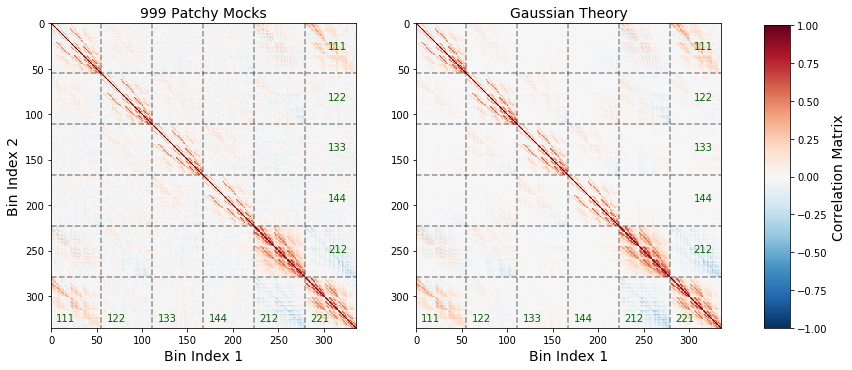

In [24]:
# Maximum number of multiplets to plot
n_max = 6

fig,ax = plt.subplots(1,2,figsize=(12,6))
# Sample correlation
im = ax[0].imshow(corrN[:n_max*n_radial,:n_max*n_radial],vmax=1,vmin=-1,cmap=cm.RdBu_r);
# Theory correlation
im = ax[1].imshow(theory_corrN[:n_max*n_radial,:n_max*n_radial],vmax=1,vmin=-1,cmap=cm.RdBu_r);
for i in range(n_max):
    for a in range(2):
        if i!=0: ax[a].hlines(n_radial*i-1,0,n_max*n_radial,linestyles='--',alpha=0.4)
        if i!=0: ax[a].vlines(n_radial*i-1,0,n_max*n_radial,linestyles='--',alpha=0.4)
        if i!=n_max-1: ax[a].text(n_radial*(n_max-1)+n_radial/10+20,n_radial*i+n_radial/2,'%d%d%d'%(ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i]),color='darkgreen',size=10)
        ax[a].text(n_radial*i+n_radial/10,n_radial*(n_max-1)+n_radial/2+20,'%d%d%d'%(ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i]),color='darkgreen',size=10)
for a in range(2):
    ax[a].set_xlim([0,n_radial*n_max-1])
    ax[a].set_ylim([n_radial*n_max-1,0])
ax[0].set_title('%d Patchy Mocks'%n_mocks,fontsize=14)
ax[1].set_title('Gaussian Theory',fontsize=14);
for a in range(2): ax[a].set_xlabel(r'Bin Index 1',fontsize=14)
ax[0].set_ylabel(r'Bin Index 2',fontsize=14)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
cbar=fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Correlation Matrix',fontsize=14)

fig.savefig(plot_dir+'correlation_comparison_ngc.pdf',bbox_inches='tight')

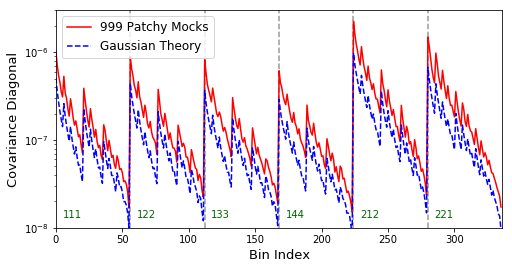

In [25]:
plt.figure(figsize=(8,4))
# Sample variance
plt.plot(np.diag(covN)[:n_max*n_radial],c='r',ls='-',label='%d Patchy Mocks'%n_mocks)
# Theory variance
plt.plot(np.diag(theory_covN)[:n_max*n_radial],c='b',ls='--',label='Gaussian Theory')
plt.yscale('log')
plt.xlim([0,n_max*n_radial])
ylims = [1e-8,3e-6]
plt.ylim(ylims)
for i in range(n_max):
    if i!=0: plt.vlines(n_radial*i,ylims[0],ylims[1],linestyles='--',alpha=0.4)
    plt.text(n_radial*i+n_radial/10,ylims[0]*1.3,'%d%d%d'%(ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i]),color='darkgreen',size=10) 
plt.legend(loc='upper left',fontsize=12)
plt.xlabel(r'Bin Index',fontsize=13)
plt.ylabel(r'Covariance Diagonal',fontsize=13)

plt.savefig(plot_dir+'variance_comparison_ngc.pdf',bbox_inches='tight')

# 4) Plot Data
- We plot a selection of odd 4PCF multiplets, $\zeta_{\ell_1\ell_2\ell_3}(r_1,r_2,r_3)$ below.
- The eventual analysis makes use of all odd-parity multiplets given the above restrictions.
- The three radial bins are collapsed into one-dimension, with the restriction $r_1<r_2<r_3$.
- The first panel gives the radial bin centers and the subsequent panels give the multiplets, normalized by $r_1r_2r_3$.

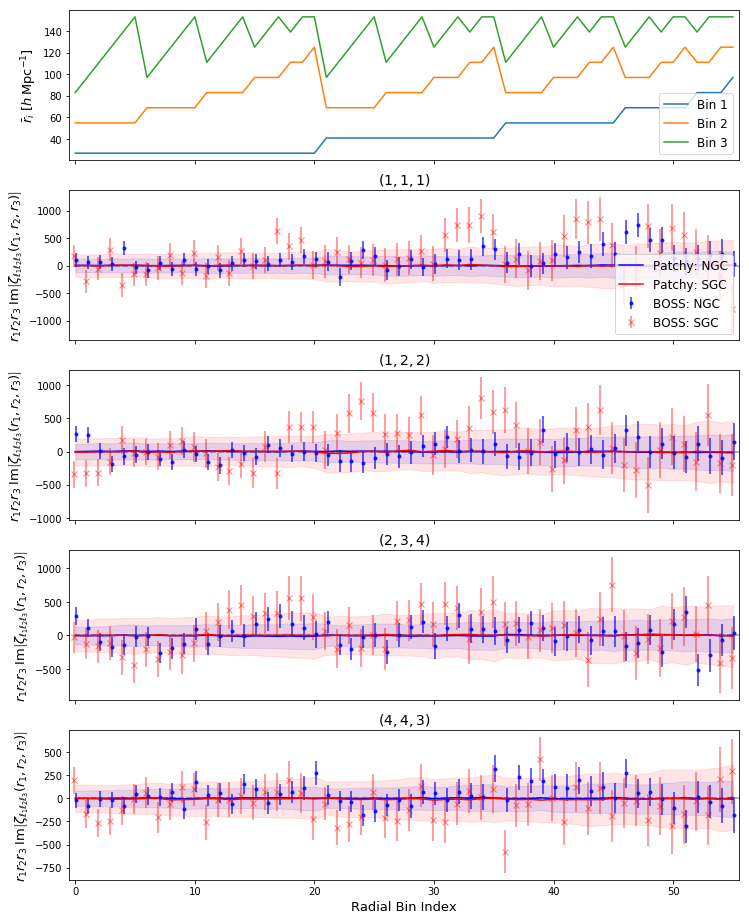

In [26]:
xmax = n_radial-1
r123 = (radii[0]*radii[1]*radii[2])[radial_filt]

# Choose which multiplet indices to plot
which_indices = [0,1,8,22]
n_plots = len(which_indices)

# Plot radial bins in first panel
fig,ax = plt.subplots(n_plots+1,figsize=(12,4*n_plots),sharex=True)
ax[0].plot(np.arange(n_radial),radii[0][radial_filt],label='Bin 1')
ax[0].plot(np.arange(n_radial),radii[1][radial_filt],label='Bin 2')
ax[0].plot(np.arange(n_radial),radii[2][radial_filt],label='Bin 3')
ax[0].set_xlim([-0.5,xmax+0.5])
ax[0].set_ylabel(r'$\bar r_i$ [$h\,\mathrm{Mpc}^{-1}$]',fontsize=13)
ax[0].legend(loc='lower right',fontsize=12)

# Define mean and variance of mocks
fourpcfN_mean = np.mean(filt_fourpcfN,axis=0)
fourpcfN_std = np.std(filt_fourpcfN,axis=0)
fourpcfS_mean = np.mean(filt_fourpcfS,axis=0)
fourpcfS_std = np.std(filt_fourpcfS,axis=0)

# Iterate over multiplets to plot
for ii,i in enumerate(which_indices):
    
    # Plot Patchy data
    ax[ii+1].fill_between(np.arange(n_radial),r123*(fourpcfN_mean[i]-fourpcfN_std[i]),
                     r123*(fourpcfN_mean[i]+fourpcfN_std[i]),color='b',alpha=0.1)
    ax[ii+1].plot(np.arange(n_radial),r123*fourpcfN_mean[i],label=r'Patchy: NGC',c='b')

    ax[ii+1].fill_between(np.arange(n_radial),r123*(fourpcfS_mean[i]-fourpcfS_std[i]),
                     r123*(fourpcfS_mean[i]+fourpcfS_std[i]),color='r',alpha=0.1)
    ax[ii+1].plot(np.arange(n_radial),r123*fourpcfS_mean[i],label=r'Patchy: SGC',c='r')
        
    # Plot BOSS data
    ax[ii+1].errorbar(np.arange(n_radial)+0.1,r123*filt_fourpcf_bossN[i],yerr=r123*fourpcfN_std[i],
                     ls='',c='b',marker='.',label=r'BOSS: NGC',alpha=0.8)
    ax[ii+1].errorbar(np.arange(n_radial)-0.1,r123*filt_fourpcf_bossS[i],yerr=r123*fourpcfS_std[i],
                     ls='',c='r',marker='x',label=r'BOSS: SGC',alpha=0.5)

    ax[ii+1].hlines(0,0,n_radial,linestyles='--',color='k',alpha=0.4)
    
    if ii==0: ax[ii+1].legend(loc='lower right',fontsize=12)
    ax[ii+1].set_ylabel(r'$r_1r_2r_3\;\mathrm{Im}\left[\zeta_{\ell_1\ell_2\ell_3}(r_1,r_2,r_3)\right]$',fontsize=13)
    ax[ii+1].set_title(r'$(%d,%d,%d)$'%(ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i]),fontsize=14);

ax[n_plots].set_xlabel(r'Radial Bin Index',fontsize=13)
fig.savefig(plot_dir+'4pcf_main_plot.pdf',bbox_inches='tight')

# 5) Perform a non-parametric rank test
- A rigorous test for parity-violation is to perform a non-parametric rank test, comparing the distribution of a test statistic measured in data to that from realistic (parity-conserving) simulations
- We first define the *pseudo*-$\chi^2$ statistic $S = [d^T \tilde{\mathsf C}^{-1} d]_\mathrm{NGC}+[d^T \tilde{\mathsf C}^{-1} d]_\mathrm{SGC}$ for theory covariance $\tilde{\mathsf{C}}$. This is a sensible choice since the data is likely close to Gaussian and the theory covariance is likely close to the truth.
- We plot the distribution of $S$ from the Patchy mocks, and add also that from the data.
- The rank of the true data gives the significance of the detection.
- This avoids (a) assuming that the theory covariance matches the true covariance and (b) assuming a likelihood for the data (*i.e.* asserting Gaussianity).

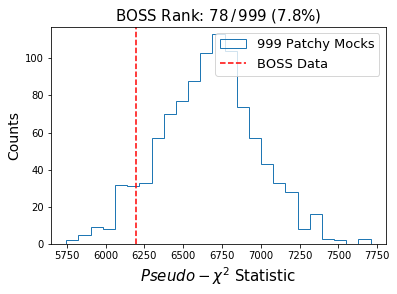

In [27]:
def pseudo_chi2(dataN, dataS):
    """Define the pseudo-chi^2 statistic from NGC and SGC BOSS data. 
    This is constructed using the (biased) theory covariance.
    We add the summaries from the two statistics together, assuming independence."""
    theoryN = np.zeros_like(dataN)
    theoryS = np.zeros_like(dataS)
    xN = np.inner(dataN-theoryN, np.inner(inv_theory_covN, dataN-theoryN))
    xS = np.inner(dataS-theoryS, np.inner(inv_theory_covS, dataS-theoryS))
    return xN + xS

pseudo_chi2_patchy = np.asarray([pseudo_chi2(filt_flat_fourpcfN[i], filt_flat_fourpcfS[i]) for i in range(n_mocks)])
pseudo_chi2_boss = pseudo_chi2(filt_flat_fourpcf_bossN,filt_flat_fourpcf_bossS)

boss_percentile = percentileofscore(pseudo_chi2_patchy,pseudo_chi2_boss)
boss_rank = boss_percentile*n_mocks/100.

plt.figure(figsize=(6,4))
ct,x,_=plt.hist(pseudo_chi2_patchy,bins=25,label='%d Patchy Mocks'%n_mocks,histtype='step');
plt.vlines(pseudo_chi2_boss,0,max(ct)+10,linestyles='--',color='r',label='BOSS Data')
plt.ylim(0,max(ct)+4)
plt.xlabel(r'${Pseudo}-\chi^2$ Statistic',fontsize=15);
plt.ylabel(r'Counts',fontsize=14)
plt.title(r'BOSS Rank: $%d\,/\,%d$ (%.1f%%)'%(boss_rank,n_mocks,boss_percentile),fontsize=15)
plt.legend(fontsize=13)
plt.savefig(plot_dir+'non-parametric-plot.pdf',bbox_inches='tight')

## 5a) Analyze with Rescaled Theory Covariance

- An alternative way in which to analyze the data is to use the *theoretical* covariance matrix to form the $\chi^2$:
$$\chi^2 = \zeta^T \mathsf{C}_{\rm theory}^{-1}\zeta$$ 
and analyze assuming Gaussian statistics. 
- We can improve the fit of theory and sample covariances by adjusting the effective survey volume (and optionally shot-noise).
- As in Hou et al. (2021), this is fit using the Kullback-Leibler divergence, comparing the true and theory covariances.
- We caution that this is **not** a robust way to analyze the data, since the theoretical covariance is unlikely to fully represent the data, even after a volume rescaling. As shown in Philcox, Hou & Slepian (2021), when this method is applied to the even-parity 4PCF, it can lead to a significant misdetection of non-Gaussianity. 
- We include the results for completeness however.

In [28]:
### First, stack the N and S data (with independent covariances)
stack_fourpcf = np.hstack([filt_flat_fourpcfN,filt_flat_fourpcfS])
stack_fourpcf_mean = np.mean(stack_fourpcf,axis=0)
stack_fourpcf_boss = np.hstack([filt_flat_fourpcf_bossN,filt_flat_fourpcf_bossS])

stack_theory_cov = np.zeros((n_mult*n_radial*2,n_mult*n_radial*2))
stack_theory_cov[:n_mult*n_radial,:n_mult*n_radial] = theory_covN
stack_theory_cov[n_mult*n_radial:,n_mult*n_radial:] = theory_covS

# Define a combined covariance matrix
inv_stack_theory_cov = np.linalg.inv(stack_theory_cov)
stack_cov = np.cov(stack_fourpcf.T)

# Compute an optimal rescaling factor
trace_disc_0 = np.trace(np.matmul(inv_stack_theory_cov,stack_cov))
logdet0 = np.linalg.slogdet(inv_stack_theory_cov)[1]
def KL_div(rescaling):
    """Use the Kullback-Leibler divergence to give the log-likelihood for the rescaling."""
    return trace_disc_0/rescaling-(logdet0-np.log(rescaling)*len(stack_theory_cov))

opt_rescaling = minimize(KL_div,1.).x
print("Optimal Rescaling: %.2fx"%opt_rescaling)

# Rescale theory matrix
opt_theory_cov = stack_theory_cov*opt_rescaling
inv_opt_theory_cov = inv_stack_theory_cov/opt_rescaling

Optimal Rescaling: 2.59x


**Compare sample and theory covariances**
- We plot the ratio of the Patchy sample covariance to the theory covariance diagonal.
- Including the volume rescaling significantly improves the fit, but it is still imperfect, with significant structure remaining.

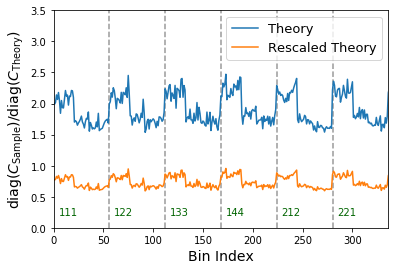

In [29]:
plt.plot(np.diag(covN)/np.diag(theory_covN),label='Theory')
plt.plot(np.diag(covN)/np.diag(opt_theory_cov)[:n_mult*n_radial],label='Rescaled Theory')
plt.ylabel(r'$\mathrm{diag}(C_{\rm Sample})/\mathrm{diag}(C_{\rm Theory})$',fontsize=14)
plt.legend(fontsize=13)#,loc='center right')
plt.xlim([0,n_max*n_radial])
plt.ylim([0,3.5])
for i in range(n_max):
    if i!=0: plt.vlines(n_radial*i,0,4,linestyles='--',alpha=0.4)
    plt.text(n_radial*i+n_radial/10,0.2,'%d%d%d'%(ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i]),color='darkgreen',size=10) 
plt.xlabel(r'Bin Index',fontsize=14)
plt.savefig(plot_dir+'fitted_variance_comparison.pdf',bbox_inches='tight')

**Plot the detection PDFs obtained from a classical $\chi^2$ analysis with a rescaled theory covariance**
- This uses the fitted-theory $\chi^2$s, and is thus not expected to be accurate.
- Both the empirical distribution of Patchy mocks and the BOSS data are plotted.
- We see the empirical distribution does not match the theory distribution, likely indicating the insufficiency of the theoretical covariance matrix.

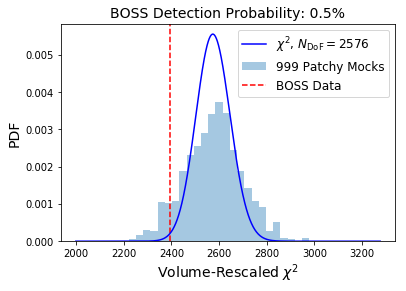

In [30]:
# Compute the chi^2 statistics
theory_model = np.zeros_like(stack_fourpcf_boss)
opt_chi2 = np.asarray([np.inner(dd-theory_model,np.inner(inv_opt_theory_cov,dd-theory_model)) for dd in stack_fourpcf])
opt_chi2_boss = np.inner(stack_fourpcf_boss-theory_model,np.inner(inv_opt_theory_cov,stack_fourpcf_boss-theory_model))

# Plot the chi^2 PDF of the Patchy mocks, the BOSS data and the analytic Gaussian PDF
bins = 25
plt.figure()
ct,x,_=plt.hist(opt_chi2,bins=bins,alpha=0.4,density=1,label=r'%d Patchy Mocks'%n_mocks)
x_arr = np.arange(min(x)*0.9,max(x)*1.1)
p = len(stack_fourpcf_boss)
chi2_pdf = chi2.pdf(x_arr,p)
boss_prob = chi2.cdf(opt_chi2_boss,p)
plt.title(r'BOSS Detection Probability: %.1f%%'%(100.*boss_prob),fontsize=14)
plt.plot(x_arr,chi2_pdf,color='blue',label=r'$\chi^2$, $N_\mathrm{DoF} = %d$'%p)
plt.vlines(opt_chi2_boss,0,2*max(ct),color='red',linestyles='--',label='BOSS Data')
plt.legend(fontsize=12);
plt.ylim([0,max([max(ct),max(chi2_pdf)])*1.05])
plt.xlabel(r'Volume-Rescaled $\chi^2$',fontsize=14)
plt.ylabel(r'PDF',fontsize=14)
plt.savefig(plot_dir+'vol_rescaled_chi2.pdf',bbox_inches='tight')

# 6) Perform data compression

- We now analyze the data using the compression scheme in Philcox, Hou \& Slepian (2021), based on Scoccimarro (2000).
- Data are projected onto the eigenvectors of the *model* inverse covariance matrix.
- This would be an optimal projection if true = model covariance, in the Gaussian limit, and is always unbiased.
- Here, the statistic is defined as $v = U^T\zeta$ where $\tilde{\mathsf C} = U\Lambda U^T$, and we keep the first $N_\mathrm{eig}$ eigenvectors, which are ordered in inverse-variance, i.e. we use those with the smallest $\Lambda$. Note that $v_{\rm theory} = 0$ under null assumptions.
- The covariance matrix of $v$ is *close* to diagonal, with $\langle vv^T \rangle = U^TC_DU$. If $C_D = \tilde{\mathsf{C}} = U\Lambda U^T$, then $\langle vv^T \rangle = \Lambda$, which is diagonal.
- The compression is performed for NGC and SGC independently, since they are assumed to be independent.

In [31]:
### Order the eigenvectors by inverse signal-to-noise
evalsN = evalsNtheory[::-1]
evecsN = evecsNtheory[:,::-1]
evalsS = evalsStheory[::-1]
evecsS = evecsStheory[:,::-1]

### Now project data
def project_data(data,N_eig,patch='ngc'):
    """Project data onto the eigenvector basis for NGC or SGC."""
    if patch=='ngc':
        these_evecs = evecsN[:,:N_eig]
    else:
        these_evecs = evecsS[:,:N_eig]
    proj_data = np.matmul(these_evecs.T,data.T).T
    return proj_data

def deproject_data(projected_data,N_eig,patch='ngc'):
    """Deproject data out of the eigenvector basis."""
    if patch=='ngc':
        these_evecs = evecsN[:,:N_eig]
    else:
        these_evecs = evecsS[:,:N_eig]
    deproj_data = np.matmul(these_evecs,projected_data.T).T
    return deproj_data

N_eig = 50
projected_fourpcfN = project_data(filt_flat_fourpcfN,N_eig,'ngc')
projected_fourpcfS = project_data(filt_flat_fourpcfS,N_eig,'sgc')
projected_fourpcf_bossN = project_data(filt_flat_fourpcf_bossN,N_eig,'ngc')
projected_fourpcf_bossS = project_data(filt_flat_fourpcf_bossS,N_eig,'sgc')

**Compressed Covariance**
- We plot the covariance matrix of the compressed 4PCF. 
- This should be close to diagonal if the projection is optimal.

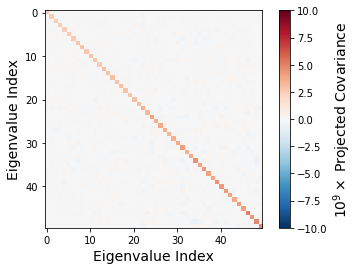

In [32]:
plt.imshow(1e9*np.cov(projected_fourpcfN.T),cmap=cm.RdBu_r,vmax=10,vmin=-10);
fs = 14
cbar = plt.colorbar();
plt.xlabel(r'Eigenvalue Index',fontsize=fs)
plt.ylabel(r'Eigenvalue Index',fontsize=fs)
cbar.set_label(r'$10^9 \times$ Projected Covariance',fontsize=fs)
plt.savefig(plot_dir+'projected_4pcf_covN.pdf',bbox_inches='tight')

**Compressed Data**
- We visualize the compressed data directly. 
- A robust detection of parity-violation would be indicated by data-points that are well separated from zero (either above or below).`

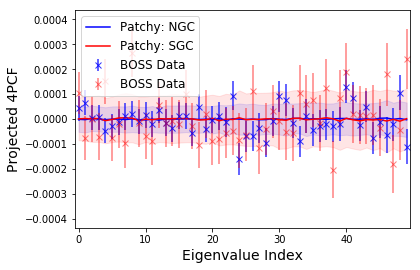

In [33]:
meanN = projected_fourpcfN.mean(axis=0)
stdN = projected_fourpcfN.std(axis=0)
meanS = projected_fourpcfS.mean(axis=0)
stdS = projected_fourpcfS.std(axis=0)
i_arr = np.arange(len(meanN))
plt.errorbar(i_arr,meanN,label='Patchy: NGC',c='b')
plt.errorbar(i_arr,meanS,label='Patchy: SGC',c='r')
plt.errorbar(i_arr,projected_fourpcf_bossN,ls='',marker='x',alpha=0.8,
             yerr=stdN,label='BOSS Data',c='b')
plt.errorbar(i_arr,projected_fourpcf_bossS,ls='',marker='x',alpha=0.5,
             yerr=stdS,label='BOSS Data',c='r')
plt.fill_between(i_arr,meanN-stdN,meanN+stdN,alpha=0.1,color='b')
plt.fill_between(i_arr,meanS-stdS,meanS+stdS,alpha=0.1,color='r')
plt.xlabel(r'Eigenvalue Index',fontsize=14)
plt.ylabel(r'Projected 4PCF',fontsize=14)
plt.xlim([-0.5,N_eig-0.5])
plt.legend(fontsize=12,loc='upper left')
vmax = np.max([np.max(projected_fourpcf_bossS+stdS),np.max(projected_fourpcf_bossN+stdN)])
plt.ylim([-vmax*1.2,vmax*1.2])
plt.savefig(plot_dir+'projected_4pcf_data.pdf',bbox_inches='tight')

# 7) Perform a Gaussian hypothesis test for the projected statistic

- Given projected data $v$, we form the test statistic:

$$T^2 = v^T\hat{\mathsf{C}}_v^{-1}v,$$
where $\hat{\mathsf{C}}$ is the projected sample covariance matrix, and we assume zero sample mean, matching the null hypothesis of no non-Gaussianity. 
- As in Sellentin & Heavens (2016), this follows a modified $F$-distribution, such that
$$T^2\sim \frac{\Gamma\left(\frac{n+1}{2}\right)}{\Gamma(p/2)\Gamma[(n-p+1)/2]}\frac{n^{-p/2}(T^2)^{p/2-1}}{(T^2/n+1)^{(n+1)/2}}$$
where $p = \mathrm{dim}(v)$ and $n = N_\mathrm{mocks}-1$.
- We can also form the conventional $\chi^2$ statistic, including the Hartlap factor required to debias noisy inverse covariance matrices:
$$H^2 = f_H\times v^T\hat{\mathsf{C}}^{-1}v,$$ where $f_H = (n-p-1)/n$. This is usually assumed to follow $\chi^2$ statistics, *i.e.* $H^2\sim \chi^2_p$, but this breaks down at small $n$.
- Both distributions are considered below. To form empirical distributions we apply jackknifing, computing the covariance from $(N-1)$ mocks and repeating.
- Below, analysis is performed for several choices of $N_\mathrm{eig}$, and we plot the detection PDFs and CDFs.
- The independent NGC and SGC measurements are summed, with their theoretical distributions obtained via a convolution.

In [ ]:
# List of numbers of basis vectors to test
N_eigs = [10,50,100]

# Number of histogram bins
bins = 25

fig1,ax1 = plt.subplots(1,len(N_eigs),figsize=(5*len(N_eigs),4))
fig2,ax2 = plt.subplots(1,len(N_eigs),figsize=(5*len(N_eigs),4),sharey=True)

for nn,N_eig in enumerate(N_eigs):
    print("\n\nN_eig = %d"%N_eig)
    
    # Project the data onto the basis
    projected_fourpcfN = project_data(filt_flat_fourpcfN,N_eig,'ngc')
    projected_fourpcfS = project_data(filt_flat_fourpcfS,N_eig,'sgc')
    projected_fourpcf_bossN = project_data(filt_flat_fourpcf_bossN,N_eig,'ngc')
    projected_fourpcf_bossS = project_data(filt_flat_fourpcf_bossS,N_eig,'sgc')
    
    ### Compute distribution of mock data using sets of (N-1) mocks, i.e. jackknifing
    this_n_mocks = len(projected_fourpcfN)-1
    
    all_T2, all_H2 = [],[]
    print("Jackknifing to compute empirical Patchy covariances. This may take a while...")
    for i in range(len(projected_fourpcfN)):
        if (i+1)%100==0: print("On step %d of %d"%(i+1,len(projected_fourpcfN)))

        # Define data
        projected_mockN = projected_fourpcfN[i]
        projected_mockS = projected_fourpcfS[i]

        # Define sample covariance in projected space
        projected_covN = np.cov(projected_fourpcfN[np.arange(len(projected_fourpcfN))!=i].T)
        projected_covS = np.cov(projected_fourpcfS[np.arange(len(projected_fourpcfS))!=i].T)
        
        # Invert the covariance
        inv_projected_covN = np.linalg.inv(projected_covN)
        inv_projected_covS = np.linalg.inv(projected_covS)

        # Compute the sample statistic
        T2_statistic = np.inner(projected_mockN,np.inner(inv_projected_covN,projected_mockN))
        T2_statistic += np.inner(projected_mockS,np.inner(inv_projected_covS,projected_mockS))
        
        all_T2.append(T2_statistic)
        
    all_T2 = np.asarray(all_T2)
    
    # Compute also Hartlap-rescaled statistic
    hartlap_factor = (this_n_mocks-N_eig-2.)/(this_n_mocks-1)
    print("Hartlap Factor for jackknifed PDF: %.3f"%hartlap_factor)
    all_H2 = all_T2*hartlap_factor
    
    ### Compute T2 and H2 statistics on BOSS data using every mmock
    projected_covN = np.cov(projected_fourpcfN.T)
    projected_covS = np.cov(projected_fourpcfS.T)
    inv_projected_covN = np.linalg.inv(projected_covN)
    inv_projected_covS = np.linalg.inv(projected_covS)
    T2_boss = np.inner(projected_fourpcf_bossN,np.inner(inv_projected_covN,projected_fourpcf_bossN))
    T2_boss += np.inner(projected_fourpcf_bossS,np.inner(inv_projected_covS,projected_fourpcf_bossS))
    hartlap_factor = (n_mocks-N_eig-2.)/(n_mocks-1)
    print("Hartlap Factor for BOSS: %.3f"%hartlap_factor)
    H2_boss = T2_boss*hartlap_factor
    
    ### Compute PDFs and CDFs (easiest to do CDFs numerically with a fine grid)
    mmax = max(all_T2)*1.5
    x_arr = np.linspace(0.001,mmax,10000)
    p = N_eig
    n = n_mocks-1
    chi2_single_pdf = chi2.pdf(x_arr,p)
    T2_single_pdf = np.float128(np.exp((p/2.-1.)*np.log(x_arr)-p/2.*np.log(n)-0.5*(n+1.)*np.log(x_arr/n+1.))*np.exp(loggamma((n+1.)/2.)-loggamma(p/2.)-loggamma((n-p+1.)/2.)))

    # Compute PDF of H^2_NGC + H^2_SGC using a convolution
    chi2_pdf = np.fft.ifft(np.fft.fft(chi2_single_pdf)**2.).real
    chi2_pdf /= np.sum(chi2_pdf)*np.diff(x_arr)[0]

    # Compute PDF of T^2_NGC + T^2_SGC using a convolution
    T2_pdf = np.fft.ifft(np.fft.fft(T2_single_pdf)**2.).real
    T2_pdf /= np.sum(T2_pdf)*np.diff(x_arr)[0]

    # Compute CDFs
    chi2_cdf = interp1d(x_arr,np.cumsum(chi2_pdf)*np.diff(x_arr)[0])
    T2_cdf = interp1d(x_arr,np.cumsum(T2_pdf)*np.diff(x_arr)[0])

    ### Plot empirical distributions
    ct,_,_=ax1[nn].hist(all_H2,bins=bins,alpha=0.4,density=1,color='orange')#,label=r'$H^2$')
    ax1[nn].hist(all_T2,bins=bins,alpha=0.4,density=1,color='blue')#,label=r'$T^2$');
    ax1[nn].vlines(T2_boss,0,2*mmax,color='blue',linestyles='--')
    ax1[nn].vlines(H2_boss,0,2*mmax,color='orange',linestyles='--')
    
    ### Plot theoretical distributions
    ax1[nn].plot(x_arr,chi2_pdf,color='orange',label=r'$H^2$')
    ax1[nn].plot(x_arr,T2_pdf,color='blue',label=r'$T^2$')
    
    ### Add cosmetics
    if nn==0:
        ax1[nn].legend(fontsize=12);
    ax1[nn].set_xlim([0,mmax])
    ax1[nn].set_ylim([0,max([max(ct),max(chi2_pdf)])*1.05])
    ax1[nn].set_xlabel(r'$H^2$ or $T^2$',fontsize=14)
    if nn==0: ax1[nn].set_ylabel(r'PDF',fontsize=14)
    ax1[nn].set_title(r'$N_\mathrm{eig} = %d$'%N_eig,fontsize=14);
    if nn==2: fig1.savefig(plot_dir+'projected_pdfs_all.pdf',bbox_inches='tight')

    ### Compute detection probabilities, as a 1-tail test
    prob_T2 = T2_cdf(all_T2)
    prob_chi2 = chi2_cdf(all_H2)

    prob_T2_boss = T2_cdf(T2_boss)
    prob_chi2_boss = chi2_cdf(H2_boss)

    # Count fraction of false detections 
    N_detections_T2 = (np.sum(prob_T2>0.95))*1./n_mocks
    N_detections_chi2 = (np.sum(prob_chi2>0.95))*1./n_mocks

    print("\nFraction of 2-sigma detections with %d eigenvalues"%N_eig)
    print("chi^2 + Hartlap model: %.3f"%N_detections_chi2)
    print("T^2: %.3f"%N_detections_T2)
    print("Expected: %.3f"%(0.05))

    # Count fraction of values outside the 95\% region 
    N_detections_T2_twosided = (np.sum(prob_T2>0.975)+np.sum(prob_T2<0.025))*1./n_mocks
    N_detections_chi2_twosided = (np.sum(prob_chi2>0.975)+np.sum(prob_chi2<0.025))*1./n_mocks

    print("\nFraction of mocks outside the 95%% region with %d eigenvalues"%N_eig)
    print("chi^2 + Hartlap model: %.3f"%N_detections_chi2_twosided)
    print("T^2: %.3f"%N_detections_T2_twosided)
    print("Expected: %.3f"%(0.05))

    print("\nBOSS Detection Rates:")
    print("chi^2 + Hartlap model: %.3f"%prob_chi2_boss)
    print("T^2: %.3f"%prob_T2_boss)
    print("Effective Sigmas: %.2f"%np.sqrt(-2.*np.log(1.-prob_T2_boss)))

    ### Histogram the detection PDFs
    ax2[nn].set_title(r'BOSS: %.1f%%'%(100.*prob_T2_boss),fontsize=14)
    ct,_,_=ax2[nn].hist(prob_chi2,bins=bins,histtype='step',color='orange',label=r'$H^2$',density=0,range=[0,1.00001]);
    ax2[nn].hist(prob_T2,bins=bins,histtype='step',color='blue',label=r'$T^2$',density=0,range=[0,1.00001]);
    ax2[nn].hlines(n_mocks/bins,0,1,linestyles='--')
    ax2[nn].vlines(prob_chi2_boss,0,max(ct)*2,color='orange',linestyles='--')
    ax2[nn].vlines(prob_T2_boss,0,max(ct)*2,color='blue',linestyles='--')
    ax2[nn].set_xlim([0.0,1])
    ax2[nn].fill_betweenx(np.arange(0,max(ct)*2),0.95,1,alpha=0.1,color='k')
    ax2[nn].set_ylim([0,max(ct)*1.1])
    if nn==0: ax2[nn].legend(fontsize=12,loc='lower right');
    if nn==0: ax2[nn].set_ylabel(r'Occurences',fontsize=14)
    ax2[nn].set_xlabel(r'Detection Probability',fontsize=14);
    if nn==2:
        fig2.savefig(plot_dir+'projected_cdfs_all.pdf',bbox_inches='tight')



N_eig = 10
Jackknifing to compute empirical Patchy covariances. This may take a while...
On step 100 of 999
On step 200 of 999
On step 300 of 999
On step 400 of 999
On step 500 of 999
On step 600 of 999
On step 700 of 999
On step 800 of 999
On step 900 of 999
Hartlap Factor for jackknifed PDF: 0.989
Hartlap Factor for BOSS: 0.989

Fraction of 2-sigma detections with 10 eigenvalues
chi^2 + Hartlap model: 0.041
T^2: 0.040
Expected: 0.050

Fraction of mocks outside the 95% region with 10 eigenvalues
chi^2 + Hartlap model: 0.048
T^2: 0.047
Expected: 0.050

BOSS Detection Rates:
chi^2 + Hartlap model: 0.466
T^2: 0.467
Effective Sigmas: 1.12


N_eig = 50
Jackknifing to compute empirical Patchy covariances. This may take a while...
On step 100 of 999
On step 200 of 999


# 8) Compare to the Chern-Simons 4PCF Model

- A possible source of parity-violation in the isotropic 4PCF is given by Chern-Simons interactions in the early Universe, between a pseudo-scalar axion and the electromagnetic field
- As demonstrated in [Shiraishi 2016](https://arxiv.org/abs/1608.00368) for the CMB and Philcox (2021) for LSS, this model leads to a definite shape in the isotropic 4PCF of galaxies, whose amplitude we can probe.
- Below, we place constraints on the template amplitude, $A_{\rm CS}$, by performing a classical $\chi^2$ analysis in the compressed subspace, using the sample covariance matrices, and assuming Gaussianity. 
- Unlike previously, we choose the basis vectors by maximizing signal-to-noise, to obtain tightest constraints on the Chern-Simons model.
- The templates may be constructed for arbitrary $\ell_{\rm max}$ and binning schemes using the accompanying Python code ```compute_cs_4pf.py```. We provide a template computed with the above binning parameters, including all odd multiplets up to $\ell_{\rm max} = 4$.
- To generate the template we assume the Patchy cosmology, a linear bias of $b = 2$, and use $\ell_{\rm max} = 8$  for internal angular momentum couplings.

In [ ]:
### First load in the Chern-Simons model
fourpcf_CS = np.loadtxt(data_dir+'chern_simons_4pcf_model.txt',dtype='complex')

### Take imaginary part, and restrict to the relevant radial bins
## Note that there is an additional factor of -1 in the template definition
filt_fourpcf_CS = fourpcf_CS.imag[:,radial_filt]*-1.

**Compare the Chern-Simons 4PCF model to data**
- For clarity, we use only the NGC region, and plot a selection of multipoles.
- A fiducial value $A_{\rm CS}=5\times 10^4$ is chosen to ensure visibility.

In [ ]:
xmax = n_radial-1
r123 = (radii[0]*radii[1]*radii[2])[radial_filt]

fiducial_amplitude = 5e4

# Choose which multiplet indices to plot
which_indices = [0,1,8,22]
n_plots = len(which_indices)

# Plot radial bins in first panel
fig,ax = plt.subplots(n_plots+1,figsize=(12,4*n_plots),sharex=True)
ax[0].plot(np.arange(n_radial),radii[0][radial_filt],label='Bin 1')
ax[0].plot(np.arange(n_radial),radii[1][radial_filt],label='Bin 2')
ax[0].plot(np.arange(n_radial),radii[2][radial_filt],label='Bin 3')
ax[0].set_xlim([-0.5,xmax+0.5])
ax[0].set_ylabel(r'$\bar r_i$ [$h\,\mathrm{Mpc}^{-1}$]',fontsize=13)
ax[0].legend(loc='lower right',fontsize=12)

# Define mean and variance of mocks
fourpcfN_mean = np.mean(filt_fourpcfN,axis=0)
fourpcfN_std = np.std(filt_fourpcfN,axis=0)
fourpcfS_mean = np.mean(filt_fourpcfS,axis=0)
fourpcfS_std = np.std(filt_fourpcfS,axis=0)

# Iterate over multiplets to plot
for ii,i in enumerate(which_indices):
    
    # Plot Patchy data
    ax[ii+1].fill_between(np.arange(n_radial),r123*(fourpcfN_mean[i]-fourpcfN_std[i]),
                     r123*(fourpcfN_mean[i]+fourpcfN_std[i]),color='b',alpha=0.1)
    ax[ii+1].plot(np.arange(n_radial),r123*fourpcfN_mean[i],label=r'Patchy: NGC',c='b')
  
    # Plot BOSS data
    ax[ii+1].errorbar(np.arange(n_radial)+0.1,r123*filt_fourpcf_bossN[i],yerr=r123*fourpcfN_std[i],
                     ls='',c='k',marker='.',label=r'BOSS: NGC',alpha=0.8)
  
    ax[ii+1].plot(np.arange(n_radial),r123*fiducial_amplitude*filt_fourpcf_CS[i],label=r'Chern-Simons Model',c='g')

    ax[ii+1].hlines(0,0,n_radial,linestyles='--',color='k',alpha=0.4)
    
    if ii==0: ax[ii+1].legend(loc='lower right',fontsize=12)
    ax[ii+1].set_ylabel(r'$r_1r_2r_3\;\mathrm{Im}\left[\zeta_{\ell_1\ell_2\ell_3}(r_1,r_2,r_3)\right]$',fontsize=13)
    ax[ii+1].set_title(r'$(%d,%d,%d)$'%(ells[0][ang_filt][i],ells[1][ang_filt][i],ells[2][ang_filt][i]),fontsize=14);

ax[n_plots].set_xlabel(r'Radial Bin Index',fontsize=13)
fig.savefig(plot_dir+'4pcf_CS_plot.pdf',bbox_inches='tight')

**Perform Parameter Inference**
- Both NGC and SGC samples are combined together, assuming independence.
- We use the $t$-distribution likelihood of Sellentin \& Heavens 2016, which gives:
$$\log L(\theta) = -\frac{N_{\rm mocks}}{2}\log\left[1+\frac{T^2(\theta)}{N_{\rm mocks}-1}\right]+ \text{const.}$$
where $T^2(\theta) = [d-m(\theta)]^TS^{-1}[d-m(\theta)]$ for (compressed) data $d$, model $m$ and sample covariance $S$.
- On physical grounds, $A_{\rm CS}$ is constrained to be positive. We can optionally impose this condition below using the ```positive_amplitude``` parameter.
- Sampling is performed using the $\texttt{emcee}$.

In [ ]:
# Sampling parameters
positive_amplitude = False
N_eig = 100
gamma = 1 # Chern-Simons coupling strength (relative to parity-even term)

In [ ]:
# Compute (squared) signal-to-noise of each eigenvector in the CS model
SN_N = np.matmul(evecsNtheory.T,filt_fourpcf_CS.ravel())**2.*evalsN
SN_S = np.matmul(evecsStheory.T,filt_fourpcf_CS.ravel())**2.*evalsS

# Order the eigenvectors in termms of signal-to-noise
orderN = np.argsort(SN_N)[::-1]
orderS = np.argsort(SN_S)[::-1]
evalsN_CS = evalsN[orderN]
evalsS_CS = evalsS[orderS]
evecsN_CS = evecsN[:,orderN]
evecsS_CS = evecsS[:,orderS]

### Project data and template
def project_data_CS(data,N_eig,patch='ngc'):
    """Project data onto the eigenvector basis for NGC or SGC."""
    if patch=='ngc':
        these_evecs = evecsN_CS[:,:N_eig]
    else:
        these_evecs = evecsS_CS[:,:N_eig]
    proj_data = np.matmul(these_evecs.T,data.T).T
    return proj_data

projected_fourpcfN = project_data_CS(filt_flat_fourpcfN,N_eig,'ngc')
projected_fourpcfS = project_data_CS(filt_flat_fourpcfS,N_eig,'sgc')
projected_fourpcf_bossN = project_data_CS(filt_flat_fourpcf_bossN,N_eig,'ngc')
projected_fourpcf_bossS = project_data_CS(filt_flat_fourpcf_bossS,N_eig,'sgc')
projected_chern_simons_templateN = project_data_CS(filt_fourpcf_CS.ravel(),N_eig,'ngc')
projected_chern_simons_templateS = project_data_CS(filt_fourpcf_CS.ravel(),N_eig,'sgc')

projected_covN = np.cov(projected_fourpcfN.T)
projected_covS = np.cov(projected_fourpcfS.T)
projected_fourpcfNmean = projected_fourpcfN.mean(axis=0)
projected_fourpcfSmean = projected_fourpcfS.mean(axis=0)
inv_projected_covN = np.linalg.inv(projected_covN)
inv_projected_covS = np.linalg.inv(projected_covS)

def T2_CS(A_CS,patch='ngc',data='BOSS'):
    """Compute T^2 statistic for a given amplitude A_{CS} of the Chern-Simons term.
    Depending on the value of 'patch', we compute either NGC or SGC results.
    If data='BOSS' we return the value for the BOSS data.
    If data='Patchy' we return the value for the mean of the Patchy mocks."""
    if patch=='ngc':
        if data=='BOSS':
            diff = projected_fourpcf_bossN-A_CS*projected_chern_simons_templateN
        elif data=='Patchy':
            diff = projected_fourpcfNmean-A_CS*projected_chern_simons_templateN
        inv_cov = inv_projected_covN
    elif patch=='sgc':
        if data=='BOSS':
            diff = projected_fourpcf_bossS-A_CS*projected_chern_simons_templateS
        elif data=='Patchy':
            diff = projected_fourpcfSmean-A_CS*projected_chern_simons_templateS
        inv_cov = inv_projected_covS
    else:
        raise Exception('Incorrect Patch!')
    T2 = np.sum(diff.T*np.matmul(inv_cov,diff.T),axis=0)
    return T2

def loglik_CS(A_CS,data='BOSS'):
    """Compute the loglikelihood of A_CS from BOSS or the mean of Patchy.
    We add the loglikelihoods of the NGC and SGC regions, assuming independence.
    On physical grounds, we enforece A_CS>0."""
    loglikN = np.log(1.+T2_CS(A_CS,'ngc',data)/(n_mocks-1.))
    loglikS = np.log(1.+T2_CS(A_CS,'sgc',data)/(n_mocks-1.))
    loglik = -n_mocks/2.*(loglikN+loglikS)
    if positive_amplitude:
        # Constrain A_CS to be positive!
        loglik -= 1e12*(A_CS<0)
    return loglik

In [ ]:
# Sample 1-parameter model using emcee
pos = 100.*np.random.randn(32, 1)
nwalkers, ndim = pos.shape

print("Computing Patchy chain")
sampler_patchy = emcee.EnsembleSampler(nwalkers, ndim, loglik_CS, kwargs={'data':'Patchy'})
sampler_patchy.run_mcmc(pos, 10000);
print("Computing BOSS chain")
sampler_boss = emcee.EnsembleSampler(nwalkers, ndim, loglik_CS, kwargs={'data':'BOSS'})
sampler_boss.run_mcmc(pos, 10000);

# Extract output samples
flat_samples_patchy = sampler_patchy.flatchain[1000::10,0]
flat_samples_boss = sampler_boss.flatchain[1000::10,0]

**Plot Histograms of Chern-Simons Amplitude**
- We plot both the $A_{\rm CS}$ 4PCF amplitude and its conversion to the physical parameter $\rho_E/\rho_\phi$
- The latter gives the ratio of the gauge field vacuum energy density and that of the inflaton.
- This depends strongly on the $\gamma$, *i.e.* the coupling strength. $\gamma = 1$ gives equal amplitude contributions from parity-even and parity-odd terms in the inflationary Lagrangian.

In [ ]:
### Load conversion between A_CS and physical ratio of energy densities
if positive_amplitude:
    print("Using |gamma| = %d, N_eig = %d and forcing A_CS to be positive"%(abs(gamma),N_eig))
else:
    print("Using |gamma| = %d, N_eig = %d and allowing both signs of A_CS"%(abs(gamma),N_eig))

N = 60 # number of e-folds of inflation
epsilon = 0.01 # slow-roll parameter
gstar_rhoE_ratio = 5.4e5/np.pi*np.exp(4.*np.pi*abs(gamma))/abs(gamma)**3.*(0.01/epsilon)*(N/60.)**2.
A_CS_gstar_ratio = 0.3/np.pi**2.*np.exp(8.*np.pi*abs(gamma))/abs(gamma)**6.*(N/60.)**2./0.01
rhoE_rhophi = lambda A_CS: A_CS/(A_CS_gstar_ratio*gstar_rhoE_ratio)

### Plot the MCMC chains
vmax = 3500
if positive_amplitude:
    vmin = 0
else:
    vmin = -vmax
nbins = 150
fig, ax1 = plt.subplots(figsize=(6,4))

# Plot constraints on A_{CS}
histy,_,_=ax1.hist(flat_samples_patchy,density=0,bins=nbins,label='Patchy-Mean',range=[vmin,vmax],alpha=0.3,color='b');
histy2,_,_=ax1.hist(flat_samples_boss,density=0,bins=nbins,label='BOSS',range=[vmin,vmax],alpha=0.3,color='r');
ax1.set_xlim([vmin,vmax])
ax1.set_ylim([0,max([max(histy),max(histy2)])*1.1])
ax1.legend(fontsize=13)
ax1.set_xlabel(r'$A_{\rm CS}$',fontsize=16)
ax1.set_ylabel(r'PDF [Arbitrary Units]',fontsize=14)

# Add constraints on rho_E/rho_phi
ax2 = ax1.twiny()
rescale_factor = 1-int(np.log10(rhoE_rhophi(vmax)))
flat_samples_boss_rho = 10.**rescale_factor*rhoE_rhophi(flat_samples_boss)
flat_samples_patchy_rho = 10.**rescale_factor*rhoE_rhophi(flat_samples_patchy)
vmax_rho = 10.**rescale_factor*rhoE_rhophi(vmax)
vmin_rho = 10.**rescale_factor*rhoE_rhophi(vmin)
ax2.hist(flat_samples_patchy_rho,density=0,bins=nbins,label='Patchy-Mean',range=[vmin_rho,vmax_rho],alpha=0.,color='r');
ax2.set_xlim([vmin_rho,vmax_rho])
ax2.set_xlabel(r'$\rho_E\,/\,\rho_\phi\,\times\,10^{%d} \quad [\gamma = %d]$'%(rescale_factor,gamma),fontsize=16)

if vmin<0:
    boss_stats = np.mean(flat_samples_boss),np.std(flat_samples_boss)
    patchy_stats = np.mean(flat_samples_patchy),np.std(flat_samples_patchy)
    boss_stats_rho = np.mean(flat_samples_boss_rho),np.std(flat_samples_boss_rho)
    patchy_stats_rho = np.mean(flat_samples_patchy_rho),np.std(flat_samples_patchy_rho)
    patchy_perc_ratio = np.percentile(rhoE_rhophi(flat_samples_patchy),95)
    print("\nBOSS 1-sigma constraints: 10^-3 A_{CS} = %.2f +- %.2f, 10^%d rho_E/rho_phi = %.2f +- %.2f"%(boss_stats[0]/1000,boss_stats[1]/1000,rescale_factor,boss_stats_rho[0],boss_stats_rho[1]))
    print("Patchy 1-sigma constraints: 10^-3 A_{CS} = %.2f +- %.2f, 10^%d rho_E/rho_phi = %.2f +- %.2f"%(patchy_stats[0]/1000,patchy_stats[1]/1000,rescale_factor,patchy_stats_rho[0],patchy_stats_rho[1]))
else:
    boss_perc = np.percentile(flat_samples_boss,95)
    patchy_perc = np.percentile(flat_samples_patchy,95)
    boss_perc_ratio = np.percentile(flat_samples_boss_rho,95)
    patchy_perc_ratio = np.percentile(flat_samples_patchy_rho,95)
    print("\nBOSS 95%% Confidence Bound: A_{CS} < %.3f x 10^3, 10^%d rho_E/rho_phi < %.1f"%(boss_perc/1000.,rescale_factor,boss_perc_ratio))
    print("Patchy 95%% Confidence Bound: A_{CS} < %.3f x 10^3, 10^%d rho_E/rho_phi < %.1f"%(patchy_perc/1000.,rescale_factor,patchy_perc_ratio))

if positive_amplitude:
    fig.savefig(plot_dir+'CS_constraints_gamma%d_N%d_posA.pdf'%(gamma,N_eig),bbox_inches='tight')
else:
    fig.savefig(plot_dir+'CS_constraints_gamma%d_N%d_allA.pdf'%(gamma,N_eig),bbox_inches='tight')

### This completes the analysis